# **COMP9727 Recommender Systems**
@Author: **name** (**zid**)

**Name**: Yang Liu  
**zID**: z5471680


## **Part 1**

Steps:
- load data and data cleaning
- text preprocessing (selecting methods)
- build X and y for topic classification
- model selection according to cross validation scores
- feature selection (number of features)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("dataset.tsv", sep='\t')
print(df.columns)
print(df['topic'].value_counts())

Index(['artist_name', 'track_name', 'release_date', 'genre', 'lyrics',
       'topic'],
      dtype='object')
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


Result of `df['topic'].value_counts()` tells us dataset is imbalanced, so that we should split the training set and validation set according to the proportion of categories, i.e. use `StratifiedKFold`.

**Answer for question 1**

The regex in tutorial removes too many special characters because that the dataset provided is already clean. We just need to use `split()` to segment the words, remove stop words and then do stemming or lemmatizing. Because it is more suitable to demonstrate the results with lemmas in the subsequent experiments, I choose to do lemmatizing instead of stemming.

Using cross-validation can provide more stable and reliable evaluation results, so in subsequent model selection experiments, I used 5-fold cross-validation scores.

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()  
def preprocess_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tags = []
    # covert tags from pos_tag to wordnet pos tag for nltk lemmatizer
    for word, tag in pos_tag(tokens):
        wn_tag =  wordnet.NOUN
        if tag.startswith('V'):
            wn_tag = wordnet.VERB
        elif tag.startswith('R'):
            wn_tag =  wordnet.ADV
        elif tag.startswith('J'):
            wn_tag =  wordnet.ADJ
        tags.append(wn_tag)
    tokens = [lemmatizer.lemmatize(word, pos=wn_tag) for word,wn_tag in zip(tokens,tags)]
    return ' '.join(tokens)
df['release_date']=df['release_date'].astype(str)
df['doc']=df[['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']].agg(' '.join, axis=1)
df['cleaned_doc'] = df['doc'].apply(preprocess_text)
df[['doc', 'cleaned_doc']].head()  # show samoles of clean data

,doc,cleaned_doc
0,loving the not real lake 2016 rock awake know ...,love real lake 2016 rock awake know go see tim...
1,incubus into the summer 2019 rock shouldn summ...,incubus summer 2019 rock summer pretty build s...
2,reignwolf hardcore 2016 blues lose deep catch ...,reignwolf hardcore 2016 blue lose deep catch b...
3,tedeschi trucks band anyhow 2016 blues run bit...,tedeschi truck band anyhow 2016 blue run bitte...
4,lukas nelson and promise of the real if i star...,lukas nelson promise real started 2017 blue th...


Before building the Multinomial Naive Bayes (MNB) model, we need to use CountVectorizer to convert the cleaned text into word frequency vectors. MNB uses these vectors to classify text according to the frequency of word occurrence.

In [5]:
def preprocess1(text):
    # only remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)
def preprocess2(text):
    # only extract lemmas
    tokens = text.split()
    tags = []
    # covert tags from pos_tag to wordnet pos tag for nltk lemmatizer
    for word, tag in pos_tag(tokens):
        wn_tag =  wordnet.NOUN
        if tag.startswith('V'):
            wn_tag = wordnet.VERB
        elif tag.startswith('R'):
            wn_tag =  wordnet.ADV
        elif tag.startswith('J'):
            wn_tag =  wordnet.ADJ
        tags.append(wn_tag)
    tokens = [lemmatizer.lemmatize(word, pos=wn_tag) for word,wn_tag in zip(tokens,tags)]
    return ' '.join(tokens)

res = []
# use original text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['doc'])
scores = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42))
res.append(('Do nothing', np.mean(scores).round(3)))

# only remove stopwords
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['doc'].apply(preprocess1))
scores = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42))
res.append(('Remove stopwords', np.mean(scores).round(3)))

# only extract lemmas
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['doc'].apply(preprocess2))
scores = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42))
res.append(('Extract lemmas', np.mean(scores).round(3)))

# final preprocess_text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_doc'])
scores = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42))
res.append(('Do both', np.mean(scores).round(3)))

res = pd.DataFrame(res, columns=["Preprocessing steps", "Accuracy"])
res

,Preprocessing steps,Accuracy
0,Do nothing,0.783
1,Remove stopwords,0.789
2,Extract lemmas,0.792
3,Do both,0.797


**Answer for question 2**

In the experiment, I compared the difference before and after removing stop words and lemmatizing. The results are shown in the table. From the experimental results, it can be seen that the accuracy of the original text are the lowest. Both removing stop words and lemmatizing can improve the accuracy of the classifier. From the comparision of the two steps of removing stop words and lemmatizing, lemmatizing can improve classifier more. 

In [6]:
res=[]
X = vectorizer.fit_transform(df['cleaned_doc'])
acc = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42)).mean().round(3)
precision = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='precision_macro').mean().round(3)
recall = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='recall_macro').mean().round(3)
f1 = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_macro').mean().round(3)
res.append(('Multinomial Naive Bayes', acc, precision, recall, f1))

acc = cross_val_score(BernoulliNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42)).mean().round(3)
precision = cross_val_score(BernoulliNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='precision_macro').mean().round(3)
recall = cross_val_score(BernoulliNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='recall_macro').mean().round(3)
f1 = cross_val_score(BernoulliNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_macro').mean().round(3)
res.append(('Bernoulli Naive Bayes', acc, precision, recall, f1))

res = pd.DataFrame(res, columns=["Method", "Accuracy", "Precision", "Recall", "F1"])
res

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Method,Accuracy,Precision,Recall,F1
0,Multinomial Naive Bayes,0.797,0.771,0.713,0.730
1,Bernoulli Naive Bayes,0.529,0.408,0.385,0.346


**Answer fro question 3**

The experimental results show that the classification evaluation indicators (accuracy, precision, recall and F1 score) of Multinomial Naive Bayes are significantly better than those of Bernoulli Naive Bayes, and the difference between each indicator is at least 20%. This shows that Multinomial Naive Bayes can classify more effectively in this text classification, indicating that it is more suitable for processing the current feature type. Considering that this experiment is a multi-category topic classification task and the dataset is class imbalanced (the minimum size of class is 82 and the maximum size of classes is 490), although the accuracy is intuitive, it may mask the performance of a few classes when the class distribution is uneven. Therefore, the average class (Macro) F1 score can better reflect the overall performance of the model in each category. Macro F1 was selected as the final model evaluation indicator.

In [7]:
print("Maximum number of features:", len(vectorizer.vocabulary_))

Maximum number of features: 9435


N = 400 gets the highest F1 score for MNB: 0.86
N = 300 gets the highest F1 score for BNB: 0.561


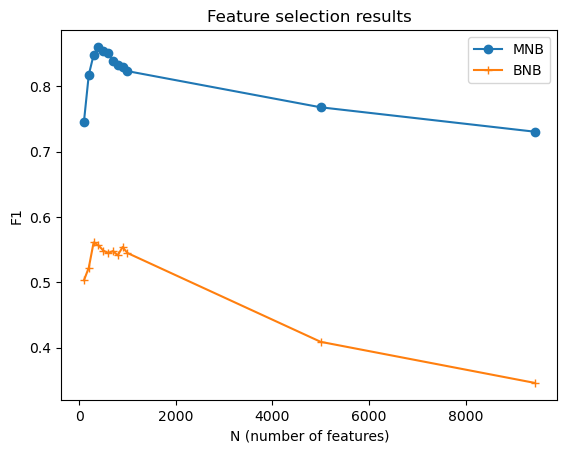

In [8]:
candidates = list(range(100, 1001, 100))+[5000, 9435]
mnbscores,bnbscores = [], []
for N in candidates:
    X = CountVectorizer(max_features=N).fit_transform(df['cleaned_doc'])
    f1 = cross_val_score(MultinomialNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_macro').mean()
    mnbscores.append(f1)
    f1 = cross_val_score(BernoulliNB(), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_macro').mean()
    bnbscores.append(f1)

# N for the highest score
mnb_max_N = candidates[np.argmax(mnbscores)]
bnb_max_N = candidates[np.argmax(bnbscores)]
print(f"N = {mnb_max_N} gets the highest F1 score for MNB: {round(max(mnbscores),3)}")
print(f"N = {bnb_max_N} gets the highest F1 score for BNB: {round(max(bnbscores),3)}")

plt.figure()
plt.plot(candidates, mnbscores, marker="o", label="MNB")
plt.plot(candidates, bnbscores, marker="+", label="BNB")
plt.xlabel('N (number of features)')
plt.ylabel('F1')
plt.title('Feature selection results')
plt.legend()
plt.show()

**Answer for question 4**

From the above results, we can see that for the MNB model, the optimal  number of features N is 400. For the BNB model, the optimal N is 300. In the following experiments, I will set max_features=400 in the Vectorizer.

**SVM model**

I choose to apply the SVM model to topic classification. 

In [9]:
X = CountVectorizer(max_features=400).fit_transform(df['cleaned_doc'])

param_grid = {
    'C': [0.001, 0.1, 1, 10, 100],   # penalty for misclassification
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # kernel
    'gamma': ['scale', 'auto'],  # for rbf kernel
}
grid_search = GridSearchCV(SVC(), param_grid, scoring='f1_macro', cv=StratifiedKFold(5, shuffle=True, random_state=42))
grid_search.fit(X, df['topic'])
print(grid_search.best_params_)

f1 = cross_val_score(SVC(**grid_search.best_params_), X, df['topic'], cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_macro').mean().round(3)
print("SVM f1 score:",f1)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM f1 score: 0.815


**Answer for question 5**

The principle of SVM is to find a hyperplane that can maximize the class interval and separate data points of different categories. The text vector model constructed based on word frequency has the characteristics of high dimension and sparseness. SVM usually performs well in such feature space, so it performs well in many text classification tasks.

Because both MNB and BNB assume that features are independent, but in fact words are not independent, there are contextual and dependency relationships, and SVM does not have this assumption, so SVM should be more suitable for topic classification task than MNB and BNB.

From experiment results, SVM didn't outperform MNB. This might be caused that we select the optimal number of features according to the results of MNB model. This value might not be suitable for SVM.

## Part 2

**Steps for question 1**
- split the data into training set and test set
- train MNB model on training data and predict topic for all data
- get user profiles:
(1) build TFIDF Vectorizers on the training set for each topic,
(2) get a TFIDF vector for each topic on the "document" that consists of all songs that user likes, **assuming that if the keywords that the user is interested in appear in the song "document", then the user "likes" this song**,
(3) extract top M words according to the TFIDF vector for each topic
- comment on the user profiles

In [10]:
# split
train_set, test_set = df.iloc[:750], df.iloc[750:1000]

In [11]:
# train and predict topic
vectorizer = CountVectorizer(max_features=400)
Xtrain = vectorizer.fit_transform(train_set['cleaned_doc'])
mnb = MultinomialNB().fit(Xtrain, train_set['topic'])
train_set.loc[:,'topic_pred'] = mnb.predict(Xtrain)

Xtest = vectorizer.transform(test_set['cleaned_doc'])
test_set.loc[:,'topic_pred'] = mnb.predict(Xtest)

C:\Users\86151\AppData\Local\Temp\ipykernel_15376\282411345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:,'topic_pred'] = mnb.predict(Xtrain)
C:\Users\86151\AppData\Local\Temp\ipykernel_15376\282411345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:,'topic_pred'] = mnb.predict(Xtest)


In [12]:
# get user profiles
def define_likes(x, kwords):
    for w in kwords:
        if w in x.split():
            return 1
    return 0
    
def build_user_profiles(train_set, keywords, M=20, flag=True):
    profiles = {}
    for topic, kwords in keywords.items():
        # 1
        docs = train_set[train_set['topic_pred']==topic]['cleaned_doc']
        vectorizer = TfidfVectorizer(max_features=400).fit(docs)  
        # 2
        train_set.loc[:,'liked'] = train_set.loc[train_set['topic_pred']==topic, 'cleaned_doc'].apply(lambda x: define_likes(x, kwords))
        liked_docs = train_set[train_set['liked']==1]['cleaned_doc'].tolist()
        vector = vectorizer.transform([" ".join(liked_docs)]).toarray()[0]
        # 3
        features = vectorizer.get_feature_names_out()
        top_idx = vector.argsort()[-M:][::-1]
        profile=[features[i] for i in top_idx]
        if flag:
            print("Topic:", topic)
            print("Interest:", kwords)
            print("Profile:", " ".join(profile))
        profiles[topic] = profile
    return profiles

print("user 1")
keywords_1 = pd.read_csv("user1.tsv",sep="\t",index_col="topic")['keywords'].apply(lambda x: [w.strip() for w in x.split(',')]).to_dict()
profiles_1 = build_user_profiles(train_set, keywords_1)

user 1
Topic: dark
Interest: ['fire', 'enemy', 'pain', 'storm', 'fight']
Profile: fight black know like blood stand grind tell gonna kill yeah lanky dilly follow hand head come people shoot rise
Topic: sadness
Interest: ['cry', 'alone', 'heartbroken', 'tears', 'regret']
Profile: cry club steal tear mean know baby music write smile say true think face eye word want blame great fear
Topic: personal
Interest: ['dream', 'truth', 'life', 'growth', 'identity']
Profile: life live change know world ordinary yeah dream wanna like thank teach lord come time beat think thing learn need
Topic: lifestyle
Interest: ['party', 'city', 'night', 'light', 'rhythm']
Profile: night closer long song come sing spoil tire home wait play time wanna tonight telephone yeah ring right lalala ready
Topic: emotion
Interest: ['love', 'memory', 'hug', 'kiss', 'feel']
Profile: good touch feel hold know morning video vision kiss loove vibe miss feelin want love luck sunrise lovin gimme lip


C:\Users\86151\AppData\Local\Temp\ipykernel_15376\2565129285.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:,'liked'] = train_set.loc[train_set['topic_pred']==topic, 'cleaned_doc'].apply(lambda x: define_likes(x, kwords))


In [13]:
print("user 2")
keywords_2 = pd.read_csv("user2.tsv",sep="\t",index_col="topic")['keywords'].apply(lambda x: [w.strip() for w in x.split(',')]).to_dict()
profiles_2 = build_user_profiles(train_set, keywords_2)

user 2
Topic: sadness
Interest: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']
Profile: inside break heart step away violence fade rainwater like blame scar open fall goodbye magnify hard go smile sing tear
Topic: emotion
Interest: ['romance', 'touch', 'feeling', 'kiss', 'memory']
Profile: touch good hold video vision kiss loove morning feelin luck sunrise lovin gimme lip look know time feel cause addiction


In [14]:
print("user 3")
keywords_3 = {'personal':['home', 'life', 'grow', 'father', 'bless'],
             'lifestyle':['party', 'drink', 'night', 'work', 'journey']}
profiles_3 = build_user_profiles(train_set, keywords_3)

user 3
Topic: personal
Interest: ['home', 'life', 'grow', 'father', 'bless']
Profile: life live thank change yeah world ordinary know like teach lord wanna want grow beat time think cause good need
Topic: lifestyle
Interest: ['party', 'drink', 'night', 'work', 'journey']
Profile: night song closer long spoil right come tire home wanna play yeah wait country want tonight telephone ring time lalala


**Analysis**

User profiles are reasonable overall. For example, under the dark topic of user 1, the profile contains a large number of words related to violence and conflicts, such as fight, blood, kill, which corresponds to this topic well. Under the sadness topic of user 1 and user 2, the profile contains words related to sad emotions such as cry, tear, heart break. Under the personal topic of user 3, the profile contains words related to life and growth such as life, live, change. Overall, the high-frequency words in the profile are highly correlated with user interests, and most words are representative of the topic, indicating that the features extracted after TFIDF sorting can reflect the user's insterests under this topic. However, there are a small number of words that are not related to the topic (open, go, write under the sadness topic), indicating that TFIDF fails to completely eliminate words with high frequency but not related to the topic.

Comparing the profile results of different users, it can be observed that the user's keywords will have a great impact on the results. The personal's keywords of virtual user 3 that I defined are not as accurate as those of user 1. Therefore, the words related to the personal topic in the profile of user 3 are less than the topic-related words in the profile of user 1.1.础。

**Steps for question 2**
- rank the songs in the test data according to the scores, where the score is defined by the number of co-occurring words between profile (top M words) and song document
- show user N songs in total and then calculate the metrics (the precision of top K recommendations)
- compare the results of various values for M

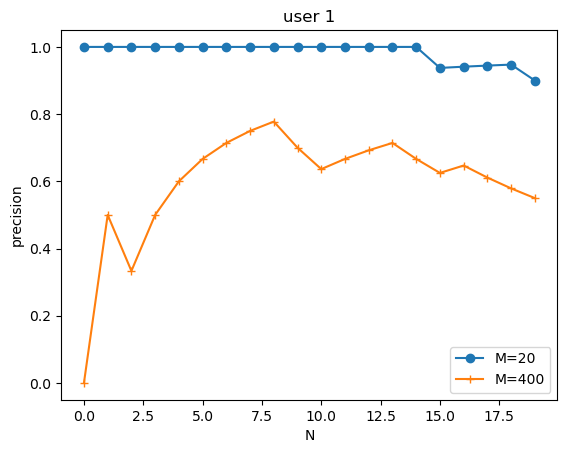

In [21]:
# rank
def recommend_evaluate(test_set, profiles, keywords, N=1):
    # combine profiles into one list
    res = [] # (idx, score)
    truth = []  # idx of songs that user like
    for idx, row in test_set.iterrows():
        if row['topic_pred'] in keywords.keys():
            if define_likes(row['cleaned_doc'], keywords[row['topic_pred']]):
                truth.append(idx)
            # matching method
            res.append((idx, len(list(set(profiles[row['topic_pred']]) & set(row['cleaned_doc'].split())))))
    res = sorted(res, key=lambda x: x[1], reverse=True)[:N]
    res = [x[0] for x in res]  #show user N songs in total 
    # calculate evaluation metrics
    num_relevant = 0
    precisions = []
    for k, item in enumerate(res):
        if item in truth:
            num_relevant += 1
        precisions.append(num_relevant / (k+1))  # precision at k
    return precisions

def show_plot(precisions_1, precisions_2, title):
    plt.figure()
    plt.plot(precisions_1, marker='o', label="M=20")
    plt.plot(precisions_2, marker='+', label="M=400")
    plt.title(title)
    plt.ylabel("precision")
    plt.xlabel("N")
    plt.legend()
    plt.show()
    
profiles_1_1 = build_user_profiles(train_set, keywords_1, M=400, flag=False)
precisions_1 = recommend_evaluate(test_set, profiles_1, keywords_1, N=20)
precisions_2 = recommend_evaluate(test_set, profiles_1_1, keywords_1, N=20)
show_plot(precisions_1, precisions_2, "user 1")

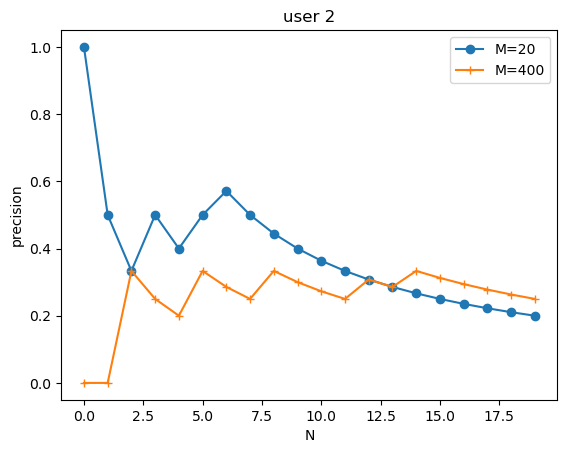

In [22]:
profiles_2_1 = build_user_profiles(train_set, keywords_2, M=400, flag=False)
precisions_1 = recommend_evaluate(test_set, profiles_2, keywords_2, N=20)
precisions_2 = recommend_evaluate(test_set, profiles_2_1, keywords_2, N=20)
show_plot(precisions_1, precisions_2, "user 2")

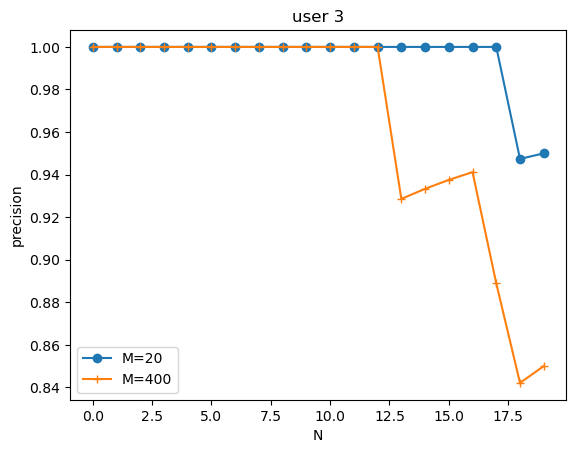

In [23]:
profiles_3_1 = build_user_profiles(train_set, keywords_3, M=400, flag=False)
precisions_1 = recommend_evaluate(test_set, profiles_3, keywords_3, N=20)
precisions_2 = recommend_evaluate(test_set, profiles_3_1, keywords_3, N=20)
show_plot(precisions_1, precisions_2, "user 3")

**Analysis**

In the experiment, I recommended N songs in total for each user. Precision was used as the main evaluation metric. From the three plots above, the performance of the recommendation method on different users varies greatly.

For User 1, when M=20, the precision is very high overall, almost close to 1, and it decreases slightly as N increases, but it always remains at a high level. When M=400, the precision is low overall, but as N increases, the precision first increases and then decreases slightly, showing a trend of first increasing and then decreasing.\
For User 2, when M=20, the precision decreases significantly as N increases. The precision is extremely high at the initial N value, but it decreases rapidly after N increases. When M=400, the precision is low overall, and shows a slight downward trend as N increases, with large overall fluctuations.\
For User 3, regardless of M=20 or M=400, the precision performance is very high, almost close to 1, and only slightly decreases when N is very large, indicating that the recommendation for this user is very accurate and stable.

For all users, the precision is generally higher when M is smaller (M=20) than when all feature words are used as the profile (M=400), indicating that the larger M is, the worse the quality of the profile is. When M=20, the precision of User 1 and User 3 is close to 1, but the drop of User 2 is more significant, indicating that the recommendation effect of User 2 is more sensitive to M, which may be because User 2 is interested in few topics. When M=400, the precision of all users drops, but User 3 remains stable, which may be because the accuracy of User 3's profile is higher.

## Part 3

**Steps for question 1**
- find a friend
- show him 3 batches of N randomly chosen songs and collect the ids of songs that he likes
- get recommendations for  week 4: (1) build TFIDF Vectorizers on the training set (first three weeks), (2) get TFIDF vectoron the "document" that consists of all songs that user likes, (3) calculate scores of the songs in test set where the score is calculated by the matching method used in part 2, (4) rank the songs by scores and recommend top 20 songs for the user
- show him N songs in total and collect the ids of songs that he likes, and then calculate the metrics (the precision of top K recommendations) 

In [18]:
# show and collect
SAMP_NUM = 10
WEEK_LEN = 250
SELECTED_IDXS = []
for week in range(3):
    base = week * WEEK_LEN
    idxs = np.random.RandomState(week).choice(np.arange(base, base+WEEK_LEN), size=SAMP_NUM, replace=False)
    SELECTED_IDXS.extend(df.iloc[idxs].index.tolist())
    print(week+1)
    display(df.iloc[idxs]['doc'])

# result from friend's score
SELECTED_IDXS_SCORES = {225: 0,  122: 1,  92: 0,  157: 0,  154: 1,  161: 0,  198: 0,  83: 1,  63: 1,  155: 0,  317: 0,  499: 1, 
                        480: 0,  411: 0,  341: 1,  474: 0,  308: 0,  484: 0,  430: 1,  254: 1,  589: 1,  591: 0,  593: 1,  
                        724: 0,  626: 1,  741: 1,  731: 1,  530: 0,  535: 1,  639: 0}

1


225    all them witches internet 2017 blues guess liv...
122    derek b bullet from a gun 2016 hip hop boot br...
92     mike ryan the rewrite 2017 country write song ...
157    billie eilish all the good girls go to hell 20...
154    black lips crystal night 2017 blues remember s...
161    uncle kracker rescue 2019 country stay late ni...
198    guts peaceful life 2016 jazz danger start futi...
83     l'indécis the god behind the pines 2017 jazz c...
63     banes world you say i'm in love 2017 pop unafr...
155    buczer hip hop prod. crackhouse 2017 hip hop g...
Name: doc, dtype: object

2


317    joe corfield shimmer 2016 jazz heaven heaven m...
499    greyhound i am what i am 2018 reggae people sc...
480    bastille million pieces 2019 rock million piec...
411    filmore heart's having a hard time 2018 countr...
341    ty segall body behavior 2018 blues pick sewer ...
474    gary clark jr. pearl cadillac 2019 blues nothi...
308    thee oh sees the daily heavy 2019 blues stop b...
484    gregory porter holding on 2016 jazz weight sho...
430    don philippe the world connects 2016 jazz buju...
254    xavier rudd fly me high 2018 reggae come eye s...
Name: doc, dtype: object

3


589    the dillinger escape plan limerent death 2016 ...
591    eric church hippie radio 2018 country daddy po...
593    hirie good vibration (feat. trevor hall) 2016 ...
724    george duke the morning, you & love 2019 jazz ...
626    nahko and medicine for the people runner 2016 ...
741    weldon irvine morning sunrise 2016 jazz mornin...
731    dorothy philadelphia 2018 blues plane tease fe...
530    the lumineers donna 2019 rock word save pictur...
535    cyrille aimee loving you 2019 jazz love choice...
639    vampire weekend sympathy 2019 rock think bedro...
Name: doc, dtype: object

In [19]:
# get recommendations
# (1)
all_samples = df.loc[SELECTED_IDXS, 'cleaned_doc'].values
vectorizer = TfidfVectorizer(max_features=400).fit(all_samples)
# (2)
liked_samples = df.loc[[i for i,v in SELECTED_IDXS_SCORES.items() if v==1], 'cleaned_doc'].values
vector = vectorizer.transform([" ".join(liked_samples)]).toarray()[0]
# (3)
features = vectorizer.get_feature_names_out()
top_idx = vector.argsort()[-20:][::-1]
profile=[features[i] for i in top_idx]

# combine profiles into one list
res = [] # (idx, score)
for idx, row in test_set.iterrows():
    # matching method
    res.append((idx, len(list(set(profile) & set(row['cleaned_doc'].split())))))
res = sorted(res, key=lambda x: x[1], reverse=True)[:SAMP_NUM]
res = [x[0] for x in res]  #show user N songs in total 
display(test_set.loc[res,'doc'])

991    grouplove good morning 2017 rock live wide awa...
801    tedeschi trucks band walk through this life 20...
875    jahmiel live without limit 2018 reggae yeah ye...
898    riley green i wish grandpas never died 2019 co...
931    trina 100% 2017 hip hop wait wait wrong oooh w...
941    adam hambrick all you, all night, all summer 2...
953    ty segall radio 2019 blues body go away give l...
969    justin moore got it good 2016 country wake mor...
990    damian marley living it up 2017 reggae daddy g...
763    jason isbell and the 400 unit white man's worl...
Name: doc, dtype: object

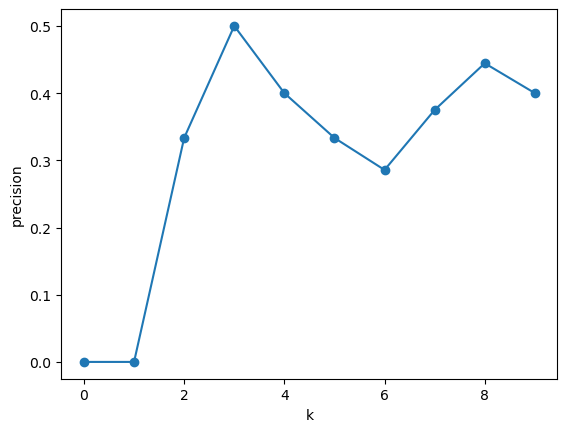

In [20]:
# result from friend's score
res_scores = {991: 0,  801: 0,  875: 1,  898: 1,  931: 0,  941: 0,  953: 0,  969: 1,  990: 1,  763: 0}

# calculate evaluation metrics
num_relevant = 0
precisions = []
for k, item in enumerate(res):
    if res_scores[item]==1:
        num_relevant += 1
    precisions.append(num_relevant / (k+1))  # precision at k
plt.figure()
plt.plot(precisions, marker='o', label='user 1')
plt.ylabel("precision")
plt.xlabel("k")
plt.show()

**Analysis**

Comparing the trend of precision in part 2, the trend in part 3 is no longer precision decreasing as k increases, but showing an upward trend. This is because in part 2, we only rely on users' keywords to judge whether they like a song, which is not the real situation, while in part 3, real user judges whether he like a song by listening to specific songs, which is more in line with the real situation of song recommendation, that is, users' liking of songs in the recommendation list tends to be more random.

The user's evaluation of the quality of the recommendatist ithat it is s qualifi. The user said, , "Overall, the songs in the recommendation list are in line with my preferences, and there are no songs I particularly dislike, but there aso one or two songs that I like very much."